In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [9]:
# read income and efficiency data
ic_in = pd.read_csv(Path('analysis_data/income_cats.csv'), index_col=0, header=None)
ef_in = pd.read_csv(Path('analysis_data/eff_io.csv'), index_col=0)

# concat into one dataframe
eff = pd.concat((ic_in, ef_in), axis=1)
eff.columns = ['income',*eff.columns[1:]]
inc = eff['income'].unique()

In [10]:
# general plot data

cmap = np.divide([[140,107,177],
                 [199,233,180],
                 [158,188,218],
                 [65,182,196]],255)       

nbins = 12


In [24]:
# read peer excel file
orient = 'io'
cid = pd.read_csv('analysis_data/country_id.csv', index_col=[1]) # country id to transform from three-letter iso code to name
xls = pd.ExcelFile(Path('analysis_data/lambdas_{0}.xlsx'.format(orient))) # so we don't have to reload the file for each sheet
peer_data = {}
sdg_strings = ['sdg{0}'.format(ii) for ii in range(1,18)]
for s in sdg_strings:
    peer_data[s] = pd.read_excel(xls, s, index_col=[0])
    peer_data[s].columns = cid['c']
    peer_data[s].index = cid['c']

cutoff = 0.001 # so we don't consider very weak peer relationships
peer_counts = {}

# count number of times a country has acted as peer, minus "self-peering"
for s in sdg_strings:
    peer_counts[s] = peer_data[s][peer_data[s] > cutoff].count() - np.diag(peer_data[s])

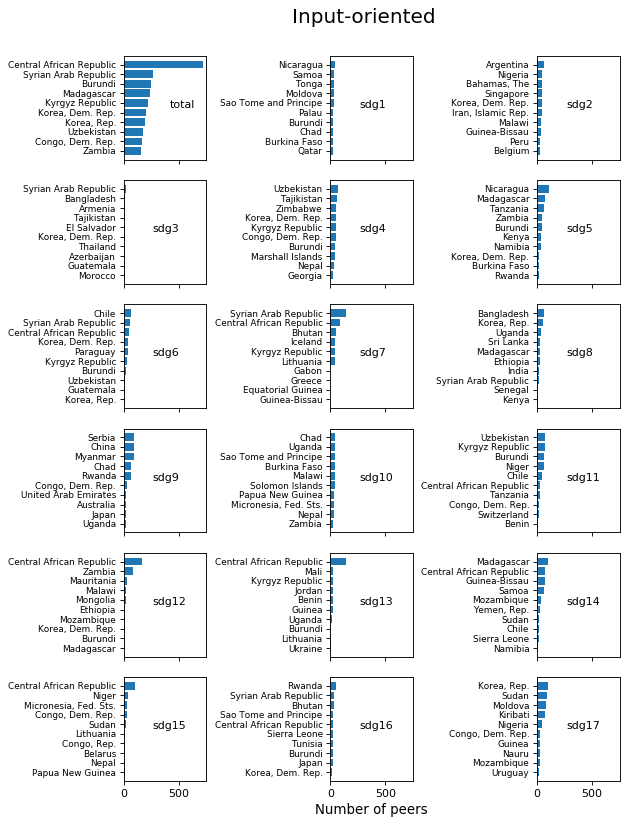

In [25]:
# plot peer counts
nc = 10 # number of countries to display

y_pos = np.arange(nc)
fig, ax = plt.subplots(6, 3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(wspace=1.5)
ax = ax.ravel()

for jj, ax0 in enumerate(ax):
    sdg_n = sdg_strings[jj-1]
    if jj==0:
        plot_counts = sum(peer_counts.values()).sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.55,.5,'total',transform=ax0.transAxes)
    else:
        plot_counts = peer_counts[sdg_n].sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.35,.5,sdg_n,transform=ax0.transAxes)

    ax0.set_yticks(y_pos)
    ax0.set_yticklabels(plot_counts.index, fontsize=8)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Number of peers", fontsize=12)
# ax3.set_ylabel("Counts", fontsize=12)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_oo.png', bbox_inches='tight', dpi=600)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_io.png', bbox_inches='tight', dpi=600)



[Text(0, 0, 'Czech Republic'),
 Text(0, 0, 'Central African Republic'),
 Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Chile'),
 Text(0, 0, 'Tajikistan'),
 Text(0, 0, 'Japan'),
 Text(0, 0, 'Mozambique'),
 Text(0, 0, 'Burkina Faso'),
 Text(0, 0, 'Korea, Dem. Rep.'),
 Text(0, 0, 'Singapore'),
 Text(0, 0, 'Switzerland'),
 Text(0, 0, 'Tanzania'),
 Text(0, 0, 'Estonia'),
 Text(0, 0, 'Denmark'),
 Text(0, 0, 'Sweden'),
 Text(0, 0, 'Korea, Rep.'),
 Text(0, 0, 'Burundi'),
 Text(0, 0, 'Iran, Islamic Rep.')]

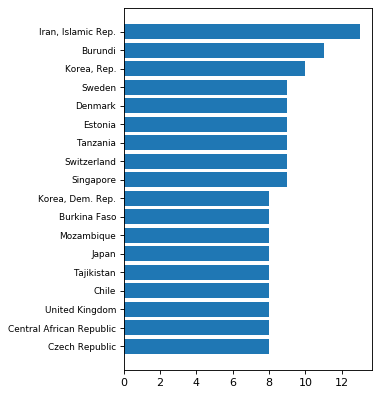

In [495]:
# which countries are most often efficient

nc = 18 # number of countries to display
freq_eff = eff[eff==1].sum(axis=1).sort_values(ascending=True)[-nc:]
freq_eff.index = [cid.loc[ii,'c'] for ii in freq_eff.index] # change country code to full name

y_pos = np.arange(nc)

fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
ax.barh(y_pos, freq_eff)
ax.set_yticks(y_pos)
ax.set_yticklabels(freq_eff.index, fontsize=8)


In [2]:
# percentile stuff

import scipy.stats
from fill_and_map import fill_econ, fill_inds_trans
econ = fill_econ(Path('data_raw/SDG-DEA_indicators_V5_20200708.xlsx'))
# inds = fill_inds_trans(Path('data_raw/SDG-DEA_indicators_V5_20200708.xlsx'))

cc = 'IRN'
for ii in econ.columns[1:]:
    pos = scipy.stats.percentileofscore(econ[ii],econ.loc[cc,ii])
    print(ii,'\t',pos)



Expenditure_on_agriculture_fishing_forestry__hunting 	 10.103626943005182
Expenditure_on_health 	 66.83937823834196
Expenditure_on_education 	 64.76683937823834
Expenditure_on_social_protection 	 72.53886010362694
Rest_of_COFOG_not_defined 	 58.29015544041451


In [20]:
# read income and efficiency data
orient = 'io'
ic_in = pd.read_csv(Path('analysis_data/income_cats.csv'), index_col=0, header=None)
ef_in = pd.read_csv(Path('analysis_data/eff_{0}.csv'.format(orient)), index_col=0)

# concat into one dataframe
eff = pd.concat((ic_in, ef_in), axis=1)
eff.columns = ['income',*eff.columns[1:]]
inc = eff['income'].unique()

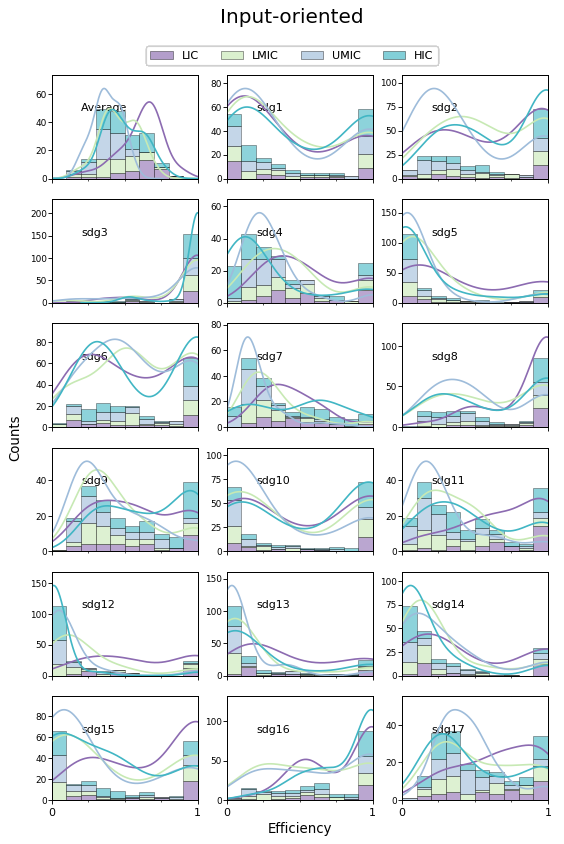

In [21]:
# stacked hist & KDE in one, every and all SDGs

aa = 0.6

def make_hist_kde(fig,ax):
    maxy2_mult = 1.15
    maxy1_mult = 1.5

    for jj,ax0 in enumerate(ax):
        ax00 = ax0.twinx()
        if jj == 0:
            histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
            ax0.text(.2,.65,'Average',transform=ax0.transAxes)
            pos1 = ax0.get_position()
        else:
            sdg_n = ''.join(('sdg',str(jj)))
            histdata = [eff[sdg_n][eff['income']==ii] for ii in inc]
            ax0.text(.2,.65,sdg_n,transform=ax0.transAxes)

        ybins, xbins, _ = ax0.hist(histdata, bins=np.linspace(0, 1, num=11), stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=aa)
        pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax00, legend=False, alpha=1)
        ax0.set_xlim(0,1)

        # automatically adjust ylim for both axes
        maxy_hist = maxy1_mult*np.stack(ybins).max()
        ax0.set_ylim(0,maxy_hist)
        maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax00.lines])
        ax00.set_ylim(0,maxy_kde)

        ax00.yaxis.set_visible(False)
        ax0.set_xticks([0,1])
        ax0.set_xticklabels([0,1])
        ax0.tick_params(axis='y', which='major', labelsize=8, pad=1)

        handles, labels = ax0.get_legend_handles_labels()
        leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=[0.5,0.9], ncol=4, bbox_transform=fig.transFigure)



fig, ax = plt.subplots(6,3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
ax = ax.ravel()
make_hist_kde(fig,ax)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Efficiency", fontsize=12)
ax3.set_ylabel("Counts", fontsize=12)


fig.suptitle('Input-oriented', y=0.95, fontsize=18)
# plt.savefig('figures/stackedhist2_kde_all_io.png', bbox_inches='tight', dpi=600)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.95, fontsize=18)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.95, fontsize=18)

plt.savefig('figures/kde_hist_{0}.png'.format(orient), bbox_inches='tight', dpi=600)



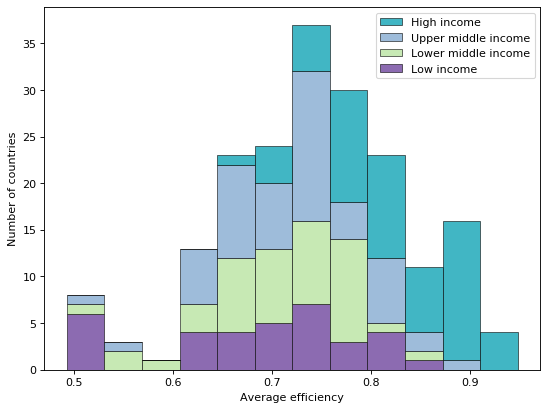

In [364]:
# histogram of average efficies across SDGs, stacked by income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
plt.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)

plt.xlabel('Average efficiency')
plt.ylabel('Number of countries')
plt.legend()

# reverse legend order
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

(0, 4)

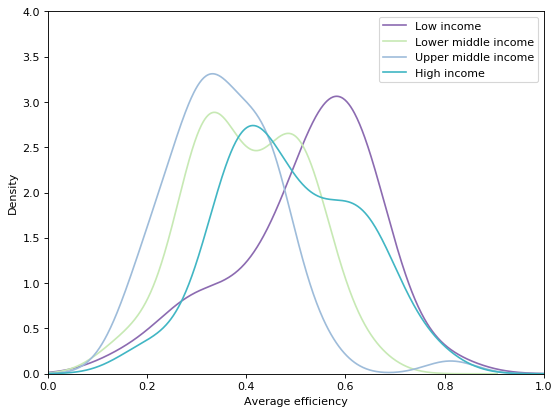

In [14]:
# KDE plot of average efficiencies across SDGs, for each income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]

ax = pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = plt.gca())
plt.xlabel('Average efficiency')
plt.ylabel('Density')
plt.legend(['High income', 'Upper middle income', 'Lower middle income', 'Low income'][::-1])
# plt.axes([0,1.2,0,4])
ax.set_xlim(0,1)
ax.set_ylim(0,4)

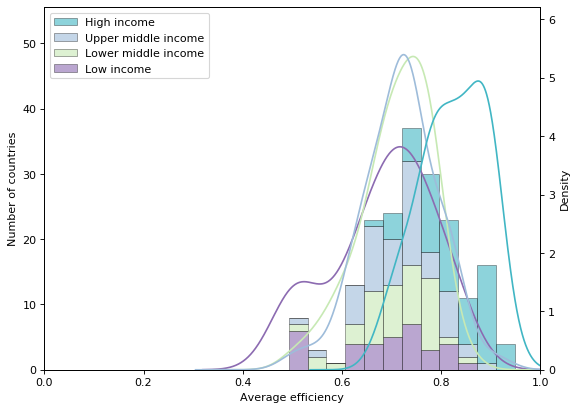

In [315]:
# stacked hist & KDE, in same plot
maxy2_mult = 1.15
maxy1_mult = 1.5

fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax2 = ax.twinx()

histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
ybins, xbins, _ = ax.hist(histdata, bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=.6)

pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax2, legend=False, alpha=1)
ax.set_xlim(0,1)

# automatically adjust ylim for both axes
maxy_hist = maxy1_mult*np.stack(ybins).max()
ax.set_ylim(0,maxy_hist)
maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax2.lines])
ax2.set_ylim(0,maxy_kde)

ax.set_ylabel('Number of countries')
# ax.set_xlabel('Average efficiency')
ax.set_xlabel('Average efficiency')
# ax.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'], loc=2)

In [ ]:
# not-so-great below, gridspec stuff with 36 subplots (lol) ------------------------



















Text(0.5, 1.0, 'Input-oriented')

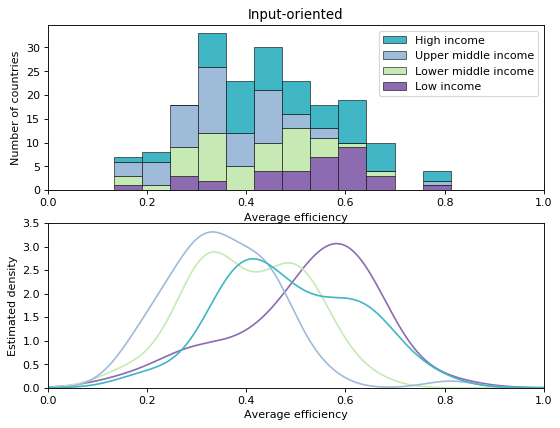

In [58]:
# stacked hist & KDE, in subplots

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6), dpi=80, sharex=False, facecolor='w', edgecolor='k')
ax1.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = ax2, legend=False)
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax2.set_ylim(0,3.5)
ax1.set_ylabel('Number of countries')
ax1.set_xlabel('Average efficiency')
ax2.set_xlabel('Average efficiency')
ax2.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

ax1.set_title('Input-oriented')

# plt.savefig('figures/stackedhist_kde_io.png', bbox_inches='tight', dpi=600)


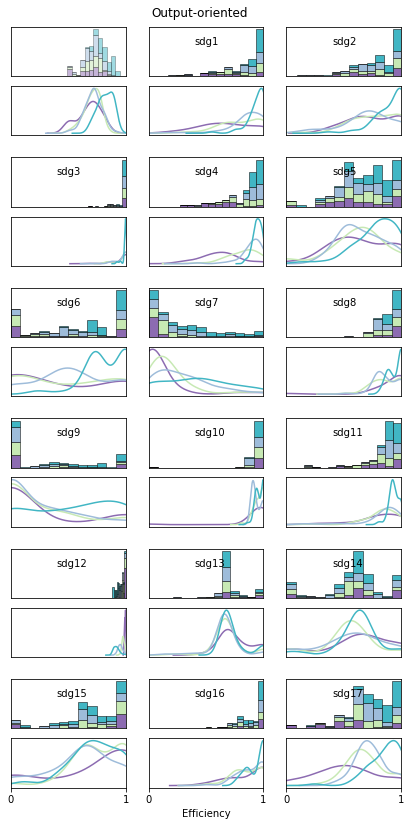

In [178]:
# stacked hist & KDE as subplots, every and all SDGs

def format_subplots(ax0,ax1):
    ax0.set_xlim(0,1)
    ax1.set_xlim(0,1)
    # ax0.set_ylim(0,100)
    # ax1.set_ylim(0,100)
    ax0.get_yaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax0.get_xaxis().set_visible(False)
    
def allsdg_hist_kde(fig):
    a = 1
    ax0 = fig.axes[0]
    ax1 = fig.axes[1]
    ax0.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
    av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
    pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
    format_subplots(ax0,ax1)
    ax1.get_xaxis().set_visible(False)
    ax0.set_ylabel('Histogram')
    ax1.set_ylabel('Density')

def onesdg_hist_kde(fig):
    for jj, (ax0,ax1) in enumerate(zip(fig.axes[2::2], fig.axes[3::2])):
        sdg_n = ''.join(('sdg',str(jj+1)))
        ax0.hist([eff[sdg_n][eff['income']==ii] for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
        single_eff = [eff[sdg_n][eff['income']==ii] for ii in inc]
        pd.concat(single_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
        format_subplots(ax0,ax1)
        ax0.text(.4,.65,sdg_n,transform=ax0.transAxes)
        if jj>=14:
            ax1.set_xticks([0,1])
            ax1.set_xticklabels([0,1])
            if jj == 15:
                ax1.set_xlabel('Efficiency')
        else:
            ax1.get_xaxis().set_visible(False)


f = plt.figure()
gs0 = gridspec.GridSpec(6, 3, figure=f)
for ii in range(18):
    gs01 = gs0[ii].subgridspec(2,1)
    f.add_subplot(gs01[0])
    f.add_subplot(gs01[1])

allsdg_hist_kde(f)
onesdg_hist_kde(f)
f.suptitle('Output-oriented', y=0.9)
f.set_size_inches([7,14])

# plt.savefig('figures/stackedhist_kde_all_oo.png', bbox_inches='tight', dpi=600)

In [ ]:
# if ax.is_last_row():
#     ax.spines['bottom'].set_visible(True)
# if ax.is_first_col():